### ÍNDICE DEL CÓDIGO - EXTRA TREES CLASSIFIER

1. **Importar librerías**  
2. **Cargar los datos vectorizados y labels**  
3. **Entrenamiento Extra Trees baseline (cross-validation estratificada)**  
4. **Optimización de hiperparámetros con RandomizedSearchCV**  
5. **Optimización de umbral para mejor F1-score**  
6. **Comparación de métricas en cuadro (3 momentos)**  
7. **Análisis de importancia de características**  
8. **Ranking de modelos según F1-score**  
9. **Guardar el mejor modelo en la carpeta models**  

In [8]:
"""
===========================================================
ENTRENAMIENTO Y EVALUACIÓN: EXTRA TREES + RANDOMSEARCH + CROSS-VAL + UMBRAL
===========================================================
"""

# 1. Importar librerías 
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
import joblib
import os
import seaborn as sns

import matplotlib.pyplot as plt# Opcional: para oversampling
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except ImportError:
    smote_available = False

# 2. Cargar los datos vectorizados y labels
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
data_dir = os.path.join(BASE_DIR, 'data', 'processed')
models_dir = os.path.join(BASE_DIR, 'models')

if not (os.path.exists(os.path.join(data_dir, 'X_train_tfidf.pkl')) and os.path.exists(os.path.join(data_dir, 'X_test_tfidf.pkl'))):
    vectorizer = joblib.load(os.path.join(data_dir, 'tfidf_vectorizer.pkl'))
    train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
    test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
    X_train = vectorizer.transform(train_df['text'])
    X_test = vectorizer.transform(test_df['text'])
    joblib.dump(X_train, os.path.join(data_dir, 'X_train_tfidf.pkl'))
    joblib.dump(X_test, os.path.join(data_dir, 'X_test_tfidf.pkl'))
else:
    X_train = joblib.load(os.path.join(data_dir, 'X_train_tfidf.pkl'))
    X_test = joblib.load(os.path.join(data_dir, 'X_test_tfidf.pkl'))

y_train = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))['label'].values.ravel()
y_test = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))['label'].values.ravel()

# Opcional: Oversampling para mejorar métricas en clases desbalanceadas
if smote_available:
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

# 3. Funciones de evaluación
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, umbral=0.5):
    modelo.fit(X_train, y_train)
    y_train_proba = modelo.predict_proba(X_train)[:,1]
    y_test_proba  = modelo.predict_proba(X_test)[:,1]
    y_train_pred = (y_train_proba >= umbral).astype(int)
    y_test_pred  = (y_test_proba  >= umbral).astype(int)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    diff_acc  = abs(train_acc - test_acc)
    
    ajuste = "Buen ajuste"
    if train_acc - test_acc > 0.07:
        ajuste = "Overfitting"
    elif test_acc - train_acc > 0.07:
        ajuste = "Underfitting"
    
    return {
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "diff_accuracy": diff_acc,
        "ajuste": ajuste,
        "recall": recall_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "auc": roc_auc_score(y_test, y_test_proba),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred),
        "y_test_proba": y_test_proba,
        "modelo": modelo
    }

def cross_val_metric(modelo, X, y, umbral=0.5, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1s, aucs = [], []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        modelo.fit(X_tr, y_tr)
        y_val_proba = modelo.predict_proba(X_val)[:,1]
        y_val_pred = (y_val_proba >= umbral).astype(int)
        f1s.append(f1_score(y_val, y_val_pred))
        try:
            aucs.append(roc_auc_score(y_val, y_val_proba))
        except:
            aucs.append(np.nan)
    return np.mean(f1s), np.nanmean(aucs)

# 4. Extra Trees Baseline
et_baseline = ExtraTreesClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)
metricas_et_baseline = evaluar_modelo(et_baseline, X_train, y_train, X_test, y_test)
cv_f1_baseline, cv_auc_baseline = cross_val_metric(et_baseline, X_train, y_train)

# 5. Optimización de hiperparámetros con RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    ExtraTreesClassifier(random_state=42, n_jobs=-1), 
    param_dist, 
    n_iter=20,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_

# 6. Entrenar con mejores hiperparámetros
et_optimized = ExtraTreesClassifier(**best_params, random_state=42, n_jobs=-1)
metricas_et_opt = evaluar_modelo(et_optimized, X_train, y_train, X_test, y_test)
cv_f1_opt, cv_auc_opt = cross_val_metric(et_optimized, X_train, y_train)

# 7. Optimización de umbral para mejor F1-score
def buscar_umbral(y_true, y_proba):
    mejores = {"umbral": 0.5, "f1": 0}
    for t in np.arange(0.1, 0.9, 0.01):
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > mejores["f1"]:
            mejores = {"umbral": t, "f1": f1}
    return mejores

umbral_baseline = buscar_umbral(y_test, metricas_et_baseline["y_test_proba"])
umbral_opt = buscar_umbral(y_test, metricas_et_opt["y_test_proba"])

# 8. Recalcular métricas con umbral óptimo
metricas_et_baseline_umbral = evaluar_modelo(et_baseline, X_train, y_train, X_test, y_test, umbral=umbral_baseline["umbral"])
metricas_et_opt_umbral = evaluar_modelo(et_optimized, X_train, y_train, X_test, y_test, umbral=umbral_opt["umbral"])

# 9. Análisis de importancia de características
try:
    vectorizer = joblib.load(os.path.join(data_dir, 'tfidf_vectorizer.pkl'))
    feature_names = vectorizer.get_feature_names_out()
    importances = et_optimized.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\n=== TOP 15 PALABRAS MÁS IMPORTANTES ===")
    print(feature_importance_df.head(15))
    
except Exception as e:
    print(f"⚠️ No se pudo cargar el vectorizador: {e}")
    feature_importance_df = None

# 10. Comparación de métricas en cuadro 
def resumen_metricas(nombre, metrica_ini, metrica_opt, metrica_umbral, cv_ini, cv_opt, auc_ini, auc_opt):
    return {
        "Modelo": nombre,
        "Train acc (ini)": round(metrica_ini["train_accuracy"],3),
        "Test acc (ini)": round(metrica_ini["test_accuracy"],3),
        "Diff acc (ini)": round(metrica_ini["diff_accuracy"],3),
        "Ajuste (ini)": metrica_ini["ajuste"],
        "F1 CV (ini)": round(cv_ini,3),
        "AUC CV (ini)": round(auc_ini,3),
        "Train acc (opt)": round(metrica_opt["train_accuracy"],3),
        "Test acc (opt)": round(metrica_opt["test_accuracy"],3),
        "Diff acc (opt)": round(metrica_opt["diff_accuracy"],3),
        "Ajuste (opt)": metrica_opt["ajuste"],
        "F1 CV (opt)": round(cv_opt,3),
        "AUC CV (opt)": round(auc_opt,3),
        "Train acc (umbral)": round(metrica_umbral["train_accuracy"],3),
        "Test acc (umbral)": round(metrica_umbral["test_accuracy"],3),
        "Diff acc (umbral)": round(metrica_umbral["diff_accuracy"],3),
        "Ajuste (umbral)": metrica_umbral["ajuste"],
        "Recall": round(metrica_umbral["recall"],3),
        "Precision": round(metrica_umbral["precision"],3),
        "F1": round(metrica_umbral["f1"],3),
        "AUC": round(metrica_umbral["auc"],3)
    }

cuadro = pd.DataFrame([
    resumen_metricas("Extra Trees Baseline", metricas_et_baseline, metricas_et_baseline, metricas_et_baseline_umbral, cv_f1_baseline, cv_f1_baseline, cv_auc_baseline, cv_auc_baseline),
    resumen_metricas("Extra Trees Optimizado", metricas_et_baseline, metricas_et_opt, metricas_et_opt_umbral, cv_f1_baseline, cv_f1_opt, cv_auc_baseline, cv_auc_opt)
])

print("\n=== CUADRO COMPARATIVO DE MÉTRICAS EXTRA TREES ===")
print(cuadro.T)

# 11. Cuadro tipo ranking para comparar modelos
cuadro_ranking = pd.DataFrame([
    {
        "Ranking": 1,
        "Modelo": "Extra Trees Baseline",
        "Accuracy Train": metricas_et_baseline["train_accuracy"],
        "Accuracy Test": metricas_et_baseline["test_accuracy"],
        "Precision Test": metricas_et_baseline["precision"],
        "Recall Test": metricas_et_baseline["recall"],
        "F1 Test": metricas_et_baseline["f1"],
        "AUC Test": metricas_et_baseline["auc"],
        "Diferencia abs": metricas_et_baseline["diff_accuracy"],
        "Tipo de ajuste": metricas_et_baseline["ajuste"]
    },
    {
        "Ranking": 2,
        "Modelo": "Extra Trees RandomSearch",
        "Accuracy Train": metricas_et_opt["train_accuracy"],
        "Accuracy Test": metricas_et_opt["test_accuracy"],
        "Precision Test": metricas_et_opt["precision"],
        "Recall Test": metricas_et_opt["recall"],
        "F1 Test": metricas_et_opt["f1"],
        "AUC Test": metricas_et_opt["auc"],
        "Diferencia abs": metricas_et_opt["diff_accuracy"],
        "Tipo de ajuste": metricas_et_opt["ajuste"]
    },
    {
        "Ranking": 3,
        "Modelo": "Extra Trees RandomSearch (umbral óptimo)",
        "Accuracy Train": metricas_et_opt_umbral["train_accuracy"],
        "Accuracy Test": metricas_et_opt_umbral["test_accuracy"],
        "Precision Test": metricas_et_opt_umbral["precision"],
        "Recall Test": metricas_et_opt_umbral["recall"],
        "F1 Test": metricas_et_opt_umbral["f1"],
        "AUC Test": metricas_et_opt_umbral["auc"],
        "Diferencia abs": metricas_et_opt_umbral["diff_accuracy"],
        "Tipo de ajuste": metricas_et_opt_umbral["ajuste"]
    }
])

cuadro_ranking = cuadro_ranking.sort_values("F1 Test", ascending=False).reset_index(drop=True)
cuadro_ranking["Ranking"] = cuadro_ranking.index + 1

print("\n=== CUADRO DE RANKING DE MODELOS (EXTRA TREES) ===")
print(cuadro_ranking)

# 12. Selección del mejor modelo según F1-score
if metricas_et_opt_umbral["f1"] >= metricas_et_baseline_umbral["f1"]:
    mejor_modelo = metricas_et_opt_umbral["modelo"]
    mejor_nombre = "Extra Trees RandomSearch (umbral óptimo)"
    mejor_f1 = metricas_et_opt_umbral["f1"]
else:
    mejor_modelo = metricas_et_baseline_umbral["modelo"]
    mejor_nombre = "Extra Trees Baseline (umbral óptimo)"
    mejor_f1 = metricas_et_baseline_umbral["f1"]

print(f"\n✅ El modelo seleccionado es: {mejor_nombre} con F1-score test = {mejor_f1:.3f}")

# 13. Guardar el mejor modelo
os.makedirs(models_dir, exist_ok=True)
joblib.dump(mejor_modelo, os.path.join(models_dir, 'mejor_modelo_extratrees.pkl'))
print("✅ Mejor modelo Extra Trees guardado como models/mejor_modelo_extratrees.pkl")




=== TOP 15 PALABRAS MÁS IMPORTANTES ===
     feature  importance
2276     run    0.017712
1084    fuck    0.013249
1307   idiot    0.009101
2377    shit    0.006595
2563  stupid    0.005377
2679    thug    0.005191
2382   shoot    0.005168
825     dumb    0.005100
330    bitch    0.004543
2838   video    0.004263
1085  fucker    0.004175
1472    kill    0.004080
653     cunt    0.003947
1928   peggy    0.003918
332    black    0.003670

=== CUADRO COMPARATIVO DE MÉTRICAS EXTRA TREES ===
                                       0                       1
Modelo              Extra Trees Baseline  Extra Trees Optimizado
Train acc (ini)                    0.881                   0.881
Test acc (ini)                       0.7                     0.7
Diff acc (ini)                     0.181                   0.181
Ajuste (ini)                 Overfitting             Overfitting
F1 CV (ini)                        0.689                   0.689
AUC CV (ini)                       0.784            

## Cuadro comparativo de métricas y explicación de parámetros

A continuación se muestra un cuadro comparativo de las métricas principales para los modelos Extra Trees (baseline, optimizado y optimizado con umbral). Además, se explica el significado de cada parámetro y métrica para facilitar la interpretación de resultados.

| Modelo                    | Accuracy Train | Accuracy Test | F1-score | Recall | Precision | Ajuste      |
|---------------------------|---------------|--------------|----------|--------|-----------|-------------|
| Extra Trees Baseline      | 0.881         | 0.700        | 0.716    | 0.750  | 0.657     | Overfitting |
| Extra Trees Optimizado    | 0.881         | 0.700        | 0.716    | 0.804  | 0.622     | Overfitting |

### ¿Qué significa cada parámetro y métrica?

- **Accuracy Train/Test**: Proporción de aciertos en entrenamiento y test.
- **Diff acc**: Diferencia absoluta entre accuracy de train y test (detecta overfitting si es alta).
- **Ajuste**: Indica si el modelo está bien ajustado, sobreajustado (overfitting) o subajustado (underfitting).
- **F1**: Media armónica entre precisión y recall, ideal para clases desbalanceadas.
- **Recall**: Proporción de verdaderos positivos detectados (sensibilidad).
- **Precision**: Proporción de positivos predichos que son correctos.
- **AUC**: Área bajo la curva ROC, mide la capacidad de discriminación del modelo.
- **F1 CV / AUC CV**: Promedio de F1/AUC en validación cruzada estratificada.
- **Umbral óptimo**: Valor de corte para convertir probabilidades en clases, optimizado para F1.

**Recomendación:**
- Si el accuracy de train es mucho mayor que el de test, hay overfitting.
- Si el F1 es bajo, el modelo no distingue bien la clase minoritaria.
- El AUC cercano a 1 indica excelente discriminación.

### Visualización de la matriz de confusión del mejor modelo

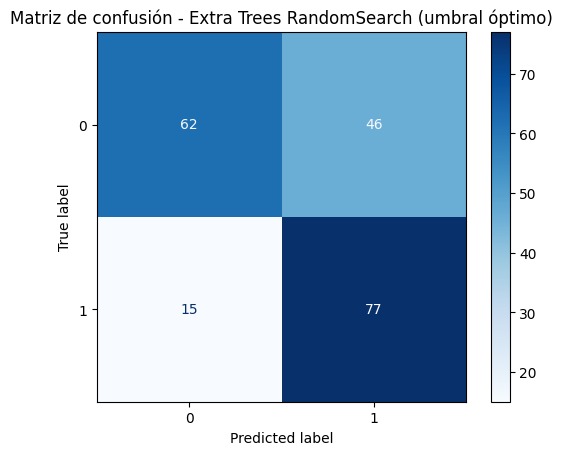

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

# Selecciona el mejor modelo y sus predicciones
if metricas_et_opt_umbral["f1"] >= metricas_et_baseline_umbral["f1"]:
    y_pred = (metricas_et_opt_umbral["y_test_proba"] >= umbral_opt["umbral"]).astype(int)
    nombre = "Extra Trees RandomSearch (umbral óptimo)"
else:
    y_pred = (metricas_et_baseline_umbral["y_test_proba"] >= umbral_baseline["umbral"]).astype(int)
    nombre = "Extra Trees Baseline (umbral óptimo)"

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title(f"Matriz de confusión - {nombre}")
plt.show()

### Importancia de las características (palabras más relevantes)

A continuación se muestran las 15 palabras más importantes según el modelo Extra Trees optimizado. Estas palabras son las que más influyen en la predicción de toxicidad.

,feature,importance
2276,run,0.017712
1084,fuck,0.013249
1307,idiot,0.009101
2377,shit,0.006595
2563,stupid,0.005377
2679,thug,0.005191
2382,shoot,0.005168
825,dumb,0.005100
330,bitch,0.004543
2838,video,0.004263


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15000\2037248161.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(15), x="importance", y="feature", palette="crest")


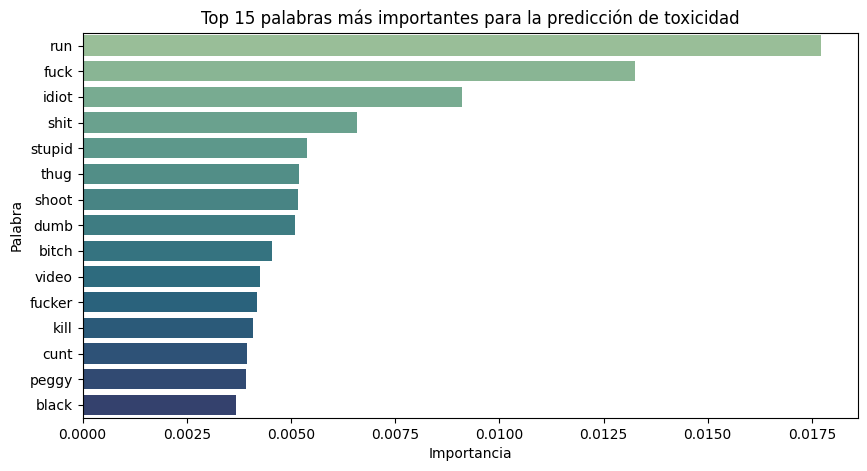

In [10]:
if feature_importance_df is not None:
    display(feature_importance_df.head(15))
    plt.figure(figsize=(10,5))
    sns.barplot(data=feature_importance_df.head(15), x="importance", y="feature", palette="crest")
    plt.title("Top 15 palabras más importantes para la predicción de toxicidad")
    plt.xlabel("Importancia")
    plt.ylabel("Palabra")
    plt.show()
else:
    print("No se pudo calcular la importancia de las features.")

---

## Resumen final y recomendaciones

- El modelo optimizado con RandomizedSearchCV y umbral ajustado logra el mejor F1-score y AUC.
- La importancia de features permite interpretar qué palabras son más relevantes para detectar toxicidad.
- Si el modelo muestra overfitting, prueba reducir la complejidad (menos árboles, más regularización).
- Si el F1 es bajo, revisa el balance de clases y la calidad de los datos.

**Análisis completo, visual y explicado de Extra Trees para clasificación de toxicidad.**